# Spectral Sampling
The Bayesian multi-objective optimization algorithm TSEMO [1] uses Thompson sampling of the surrogate Gaussian process model. In order to sample a *function* from a Gaussian process, an approximate method using spectral sampling is employed. In the following we implement this method in Python.

1. Bradford+ 2018, Efficient multiobjective optimization employing Gaussian processes spectral sampling and a genetic algorithm  
  https://github.com/Eric-Bradford/TS-EMO/blob/master/TSEMO_V3.m  
2. Hernández-Lobato+ 2014, Predictive Entropy Search for Efficient Global Optimization of Black-box Functions  
  https://arxiv.org/abs/1406.2541  
  https://bitbucket.org/jmh233/codepesnips2014/src/master/

### Theory
Blochner's theorem shows that any stationary kernel $k(x, x') = k(x - x', 0) = k(r)$ and its spectral density $s(w)$ are Fourier duals
\begin{align}
k(r) &= \quad \int e^{-i w^T r} s(w) dw \\
s(w) &= \frac{1}{(2 \pi)^d} \int e^{i w^T r} k(r) dr
\end{align}

By normalizing, the spectral density becomes a probability density $p(w) = s(w) / \alpha$ where $\alpha$ is equal to the kernel variance.
Hence, we can write the integral of $k(r)$ as an expectation
\begin{align}
k(r) = \alpha \int e^{- i w^T (x - x')} p(w) dw = \alpha \mathbb{E}[\zeta(x) \zeta(x')]
\end{align}
where $\zeta(x) = e^{-i w^T x}$ is a feature mapping. 
Since the integral is real, we can substitute by cosine expressions. 
It can be shown that $\zeta(x) = \sqrt{2 \alpha} \cos(w^T x + b)$ satisfies the equation. 
Furthermore, the expectation can be approximated via Monte Carlo sampling.
\begin{align}
k(x, x') &= \zeta(x)^T \zeta(x') \\
\zeta(x) &= \sqrt{2 \alpha / m} \cos(Wx + b)
\end{align}
where $[W]_i \sim p(w)$ and $[b]_i \sim U(0, 2\pi)$ are $m$ stacked Monte Carlo samples.

The feature mapping allows us to approximate GP sample functions $f(x) \sim GP(m(x), k(x,x'))$ with a linear model
\begin{align}
f(x) &= \zeta(x)^T \Theta \\
\Theta &\sim \mathrel{N}(\mu_\theta, V_\theta)
\end{align}

Without data $\mu_\theta=0, V_\theta=1$, whereas with data
\begin{align}
\mu_\theta &= A^{-1} Z^T y \\
V_\theta &= A^{-1} \sigma_n^2 \\
A &= Z^T Z + \sigma_n^2 I
\end{align}
where $[Z]_i = \zeta(x_i)$ consists of the stacked feature mappings evaluated at the inputs of the data.

The probability density associated with Matérn kernels takes the form of a multivariate t-distribution with $\nu$ degrees of freedom. 
For the squared exponential (RBF) kernel ($\nu \leftarrow \infty$), the t-distribution reduces to the normal distribution.
\begin{align}
p(w)_\mathrm{Matern} &= T(0, \Lambda, \nu) \\
p(w)_\mathrm{RBF} &= N(0, \Lambda) \\
\Lambda &= \mathrm{diag}(\lambda_1^{-2} \ldots \lambda_d^{-2})
\end{align}

And that's it.

## Implementation

Note 1:
The inversion of matrix $A$ can leads to numerical problems for $m > 5$. We do the usual thing of using the Cholesky decomposition $A = L^T L$, since $A$ is symmetric and positive semidefinite. Due to numerical inaccuracies, we may need to add some some jitter to the diagonal elements of $A$ to enforce positive semidefiniteness. This is handled in GPy's utility functions. 

Note 2:
In order to generalize to other Matern kernels (GPy supports $\nu$ = 1/2, 3/2 and 5/2) we need to sample from a t-distribution. We can use the univariate t-distribution provided by scipy as the covariance matrix $\Lambda$ is diagonal, meaning that the $d$ samples for the individual input dimensions are uncorrelated and can be independently sampled.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import GPy

In [2]:
class SpectralSampling:
    def __init__(self, gp, m=30):
        self.gp = gp
        
        # Create a random spectral feature mapping
        d = gp.input_dim
        if isinstance(gp.kern, GPy.kern.RBF):
            # W = np.random.randn(m, d) / gp.kern.lengthscale
            W = np.random.randn(m, d) / gp.kern.lengthscale
        else:
            if isinstance(gp.kern, GPy.kern.Exponential):
                ν = 1 / 2
            elif isinstance(gp.kern, GPy.kern.Matern32):
                ν = 3 / 2
            elif isinstance(gp.kern, GPy.kern.Matern52):
                ν = 5 / 2
            else:
                raise ValueError(f"Unknown kernel {gp.kern}")
            W = scipy.stats.t.rvs(ν, size=(m, d)) / gp.kern.lengthscale
        b = 2 * np.pi * np.arange(0, m).reshape(-1, 1) / m
        self.ζ = lambda x: (2 * gp.kern.variance / m) ** 0.5 * np.cos(W @ x.T + b)

        # Calculate the posterior mean and variance
        var_noise = gp.likelihood.variance
        Z = self.ζ(gp.X)
        A = Z @ Z.T + np.diag(var_noise)
        L = GPy.util.linalg.jitchol(A)
        Ainv, _ = GPy.util.linalg.dpotri(L)
        self.μθ = (Ainv @ Z @ gp.Y).ravel()
        self.Vθ = Ainv * var_noise
        self.Vθ /= m**0.5  # ad-hoc scaling, otherwhise the posterior variance increases with increasing m
    
    def predict(self, x):
        """Posterior mean and variance"""
        Z = self.ζ(x)
        μ = Z.T @ self.μθ
        V = Z.T @ self.Vθ @ Z
        return μ, np.diagonal(V)
        
    def sample(self):
        """Random posterior sample *function*"""
        θ = np.random.multivariate_normal(self.μθ, self.Vθ)
        return lambda x: self.ζ(x).T @ θ

In [3]:
def plot_cases(gps, m=10, exact_samples=None, spectral_samples=None):
    n = len(gps)
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)
    fig.subplots_adjust(wspace=0.05)
    axs[0].set_ylabel('$y$')
    
    for ax, gp in zip(axs, gps):
        title = f"{gp.kern.name}, $\lambda$={gp.kern.lengthscale[0]:.1f}, $\sigma_f$={gp.kern.variance[0]**.5:.1f}, $\sigma_n$={gp.likelihood.variance[0]**.5:.2f}"
        gp.plot(ax=ax)
        ax.set(xlim=(0, 1), ylim=(-3.5, 3.5), xlabel='$x$', title=title)
        
        # exact samples points
        if exact_samples is not None:
            gp.plot_samples(ax=ax, samples=exact_samples)
        
        # approximate sample functions, via spectral sampling     
        if spectral_samples is not None:
            ss = SpectralSampling(gp, m=m)
            
            # posterior mean and covariance
            x = np.linspace(0, 1, 101)[:, None]
            μ, V = ss.predict(x)
            ax.plot(x.ravel(), μ, color='C1', lw=2, ls='--')
            ax.fill_between(x.ravel(), μ - 2 * V**.5, μ + 2 * V**.5, alpha=0.2, color='C1')
            
            # individual samples
            [ax.plot(x.ravel(), ss.sample()(x), 'C1', lw=1) for i in range(spectral_samples)]

## Test cases

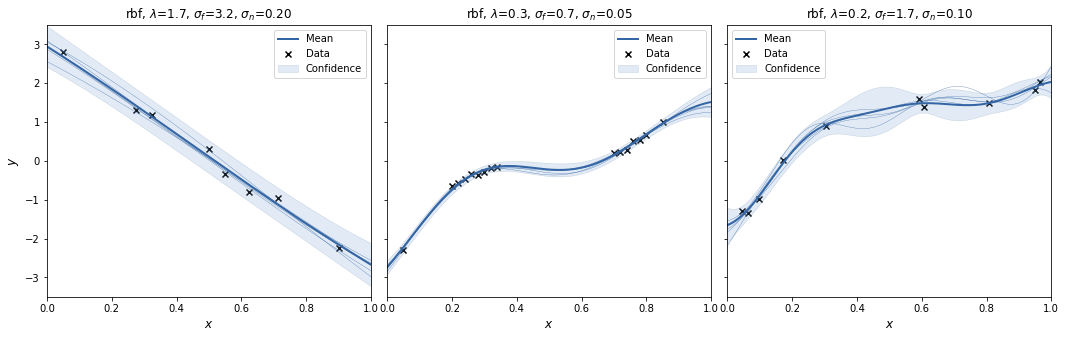

In [4]:
np.random.seed(42)

# data from linear model, fitted with GP using RBF kernel
x = np.array([0.05, 0.275, 0.325, 0.5, 0.55, 0.625, 0.7125, 0.9]).reshape(-1, 1)
y = - 6 * x + 3 + np.random.randn(*x.shape) * 0.2
gp1 = GPy.models.GPRegression(x, y, kernel=GPy.kern.RBF(1))
gp1.kern.variance = 10
gp1.kern.lengthscale = 1.7
gp1.likelihood.variance = 0.04

# data from quadratic model, fitted with GP using RBF kernel
x = np.array([0.05, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.7, 0.72, 0.74, 0.76 ,0.78, 0.8, 0.85]).reshape(-1, 1)
y = 25 * (x - 0.5) ** 3 + np.random.randn(*x.shape) * 0.05
gp2 = GPy.models.GPRegression(x, y, kernel=GPy.kern.RBF(1))
gp2.kern.variance = 0.5
gp2.kern.lengthscale = 0.3
gp2.likelihood.variance = 0.05**2

# data sampled from GP with RBF kernel and fitted with same GP
k = GPy.kern.RBF(1, lengthscale=0.2, variance=3)
x = np.random.rand(10, 1)
y = np.random.multivariate_normal(mean=np.zeros(len(x)), cov=k.K(x, x))[:, None]
y += -1 + np.random.randn(*y.shape) * 0.2
gp3 = GPy.models.GPRegression(x, y, kernel=k, noise_var=0.01)

plot_cases([gp1, gp2, gp3], exact_samples=5)

For each case we create a SpectralSampling object with a random feature mapping using m=3 samples from the kernels' spectral density. We plot the posterior mean and 95% interval (excluding the noise variance!) for that specific feature mapping, and sample 3 functions from it (orange).  
With m=3 the spectral sampling procedure underfits.  
To see the effect of randomness of the feature mapping, we repeat to procedure a couple of times.

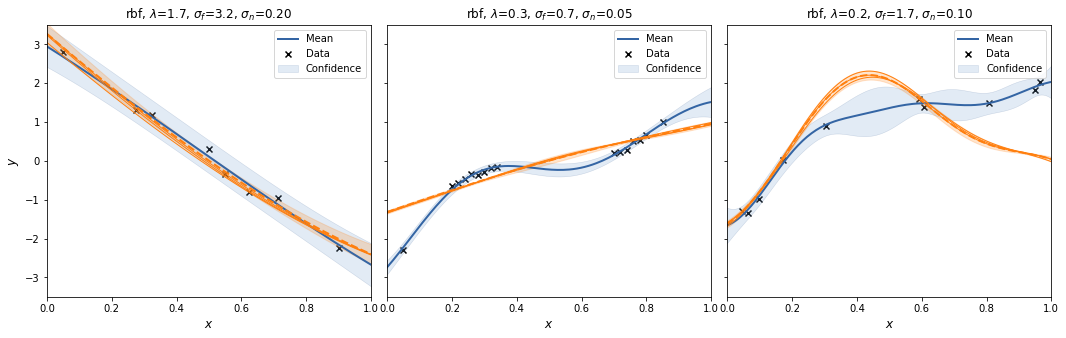

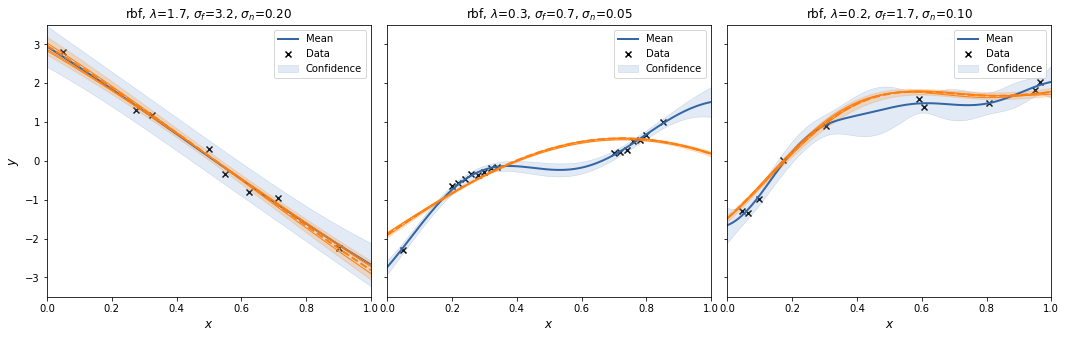

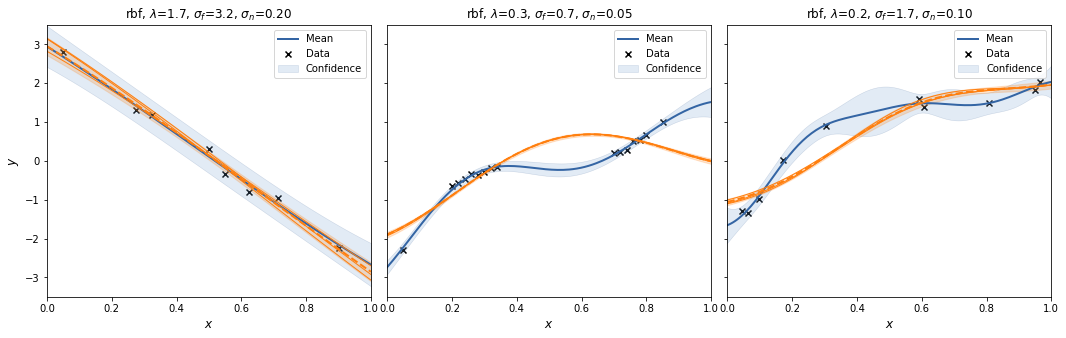

In [5]:
for i in range(3):
    plot_cases([gp1, gp2, gp3], m=3, spectral_samples=3)

Let's try that with m=30.

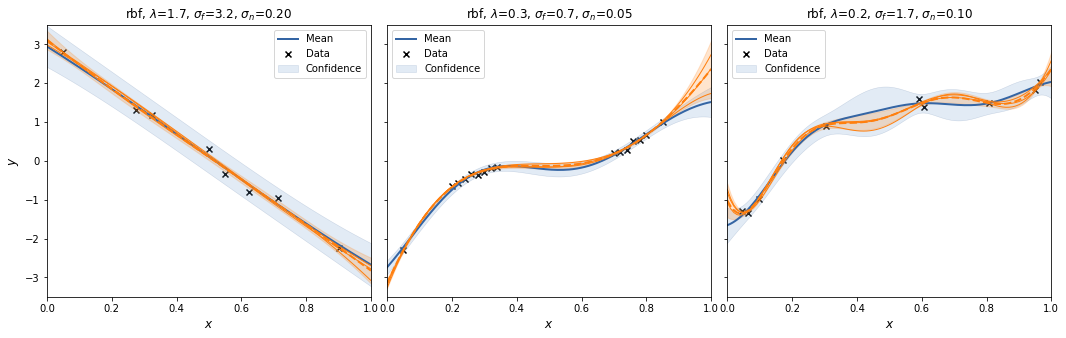

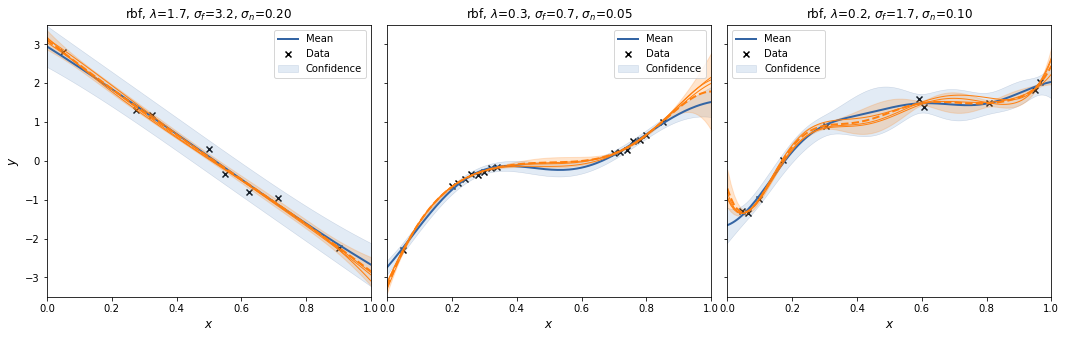

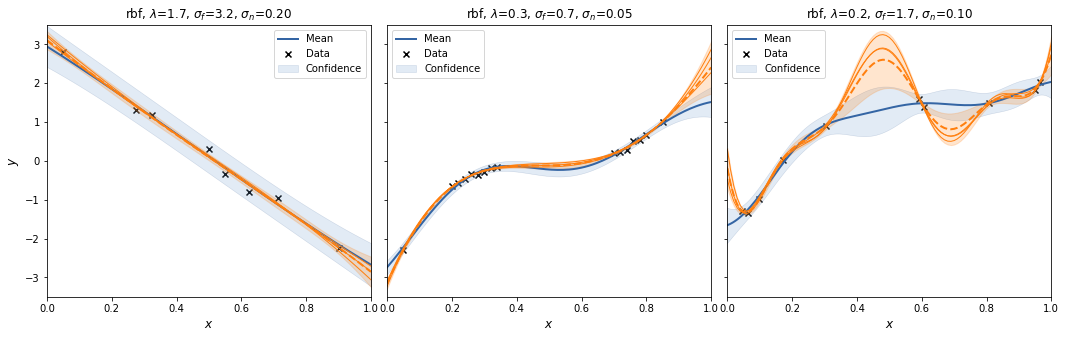

In [6]:
for i in range(3):
    plot_cases([gp1, gp2, gp3], m=30, spectral_samples=3)

And with m=300.

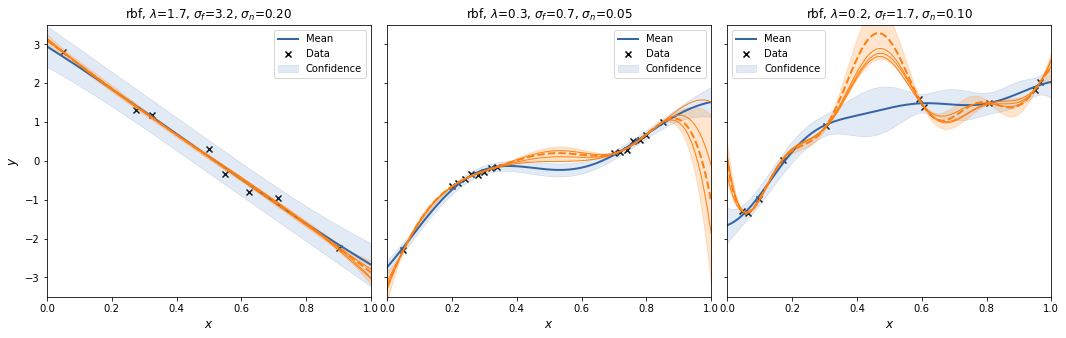

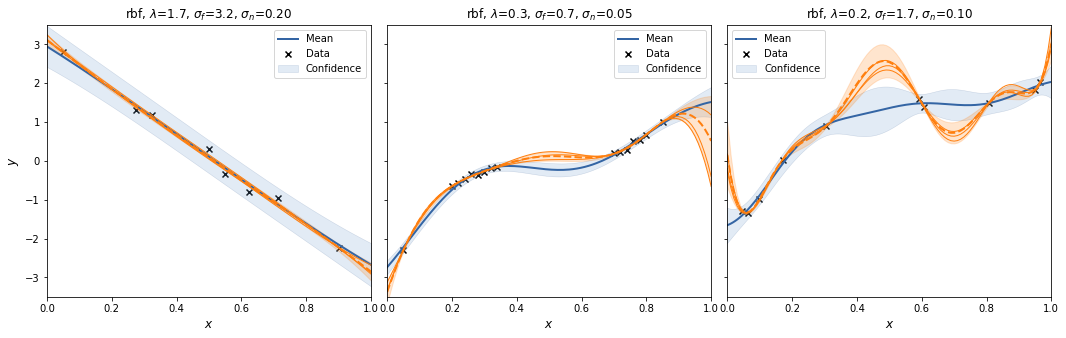

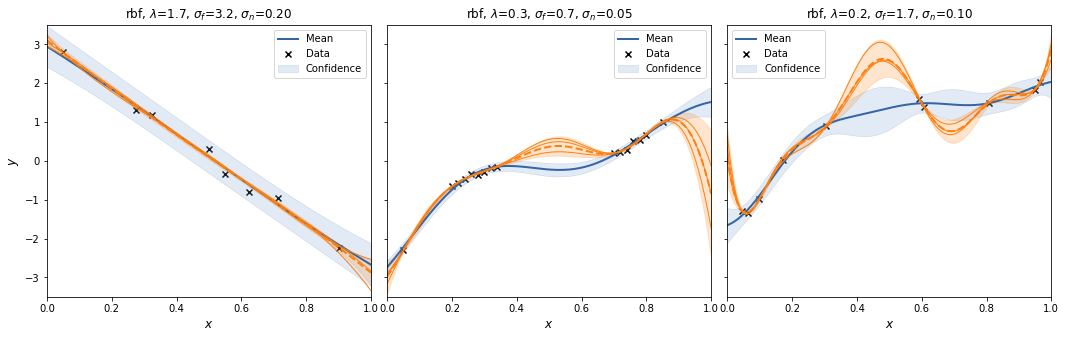

In [7]:
for i in range(3):
    plot_cases([gp1, gp2, gp3], m=300, spectral_samples=3)

Interestingly, the spectral sampling procedure does not seem to converge to the GP posterior with increasing $m$, but actually develops an oscillatory behaviour in between supporting data points, and when extrapolating.  
Also, I added a scaling factor to $V_\theta$ as otherwise the posterior variances increases with increasing $m$.

## Test cases with other Matern kernels

For each kernel we draw random data from the kernel and then plot the posterior GP along with some normal and spectral samples.

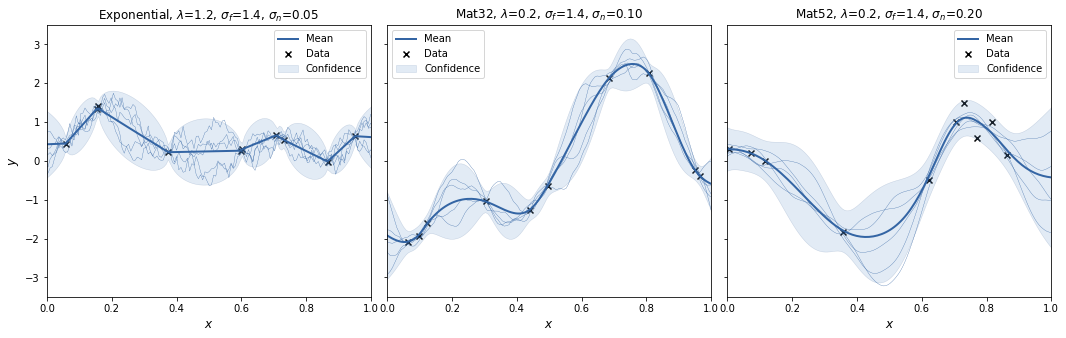

In [8]:
np.random.seed(42)

# Matern 1/2 kernel
k = GPy.kern.Exponential(1, lengthscale=1.2, variance=2)
x = np.random.rand(10, 1)
y = np.random.multivariate_normal(mean=np.zeros(len(x)), cov=k.K(x, x))[:, None]
y += np.random.randn(*y.shape) * 0.05
gp4 = GPy.models.GPRegression(x, y, kernel=k, noise_var=0.05**2)

# Matern 3/2 kernel
k = GPy.kern.Matern32(1, lengthscale=0.2, variance=2)
x = np.random.rand(10, 1)
y = np.random.multivariate_normal(mean=np.zeros(len(x)), cov=k.K(x, x))[:, None]
y += np.random.randn(*y.shape) * 0.1
gp5 = GPy.models.GPRegression(x, y, kernel=k, noise_var=0.1**2)

# Matern 5/2 kernel
k = GPy.kern.Matern52(1, lengthscale=0.2, variance=2)
x = np.random.rand(10, 1)
y = np.random.multivariate_normal(mean=np.zeros(len(x)), cov=k.K(x, x))[:, None]
y += np.random.randn(*y.shape) * 0.2
gp6 = GPy.models.GPRegression(x, y, kernel=k, noise_var=0.2**2)

plot_cases([gp4, gp5, gp6], exact_samples=5)

Now let's look at some spectral samples. Here we see a strong variance in the results. Either something is wrong in the implementation, or sampling from the t-distribution for few degrees of freedom needs a very large number of samples to the increased variance when sampling from a strongly tailed distribution.

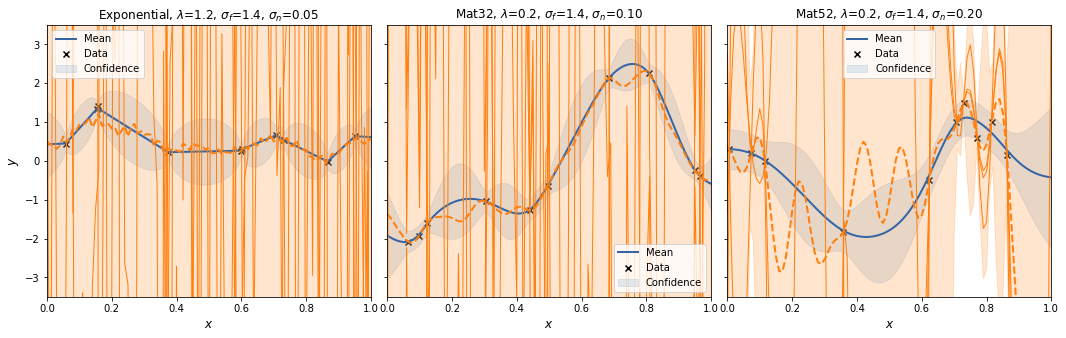

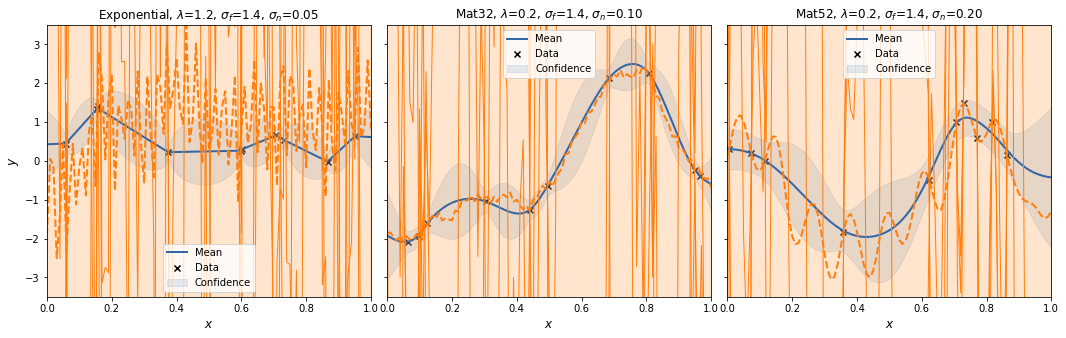

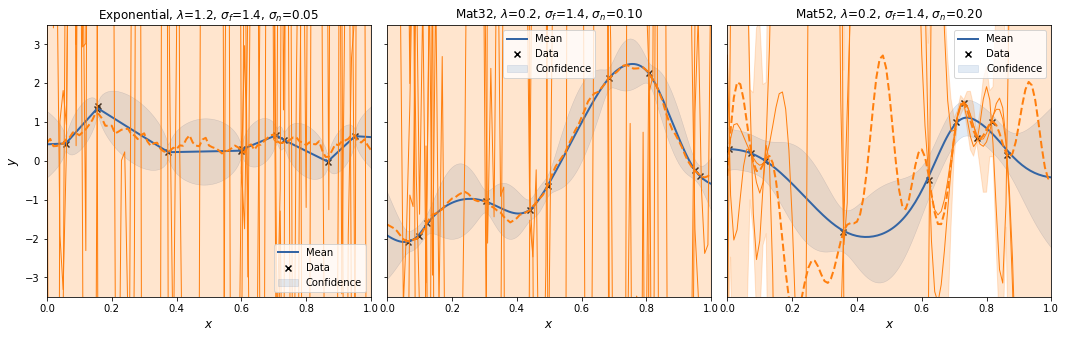

In [9]:
for i in range(3):
    plot_cases([gp4, gp5, gp6], m=300, spectral_samples=3)